# Recurrent Neural Network forecasting

- Reference:`keras.layers.SimpleRNN`

**Basic Architecture diagram**  

<img src="./pic/RNN.png" alt="RNN Architecture" width="500"/>

- U,V,W are weight matrix.
- Input: vector $X_t$ is input for network at time step t.  
- Hidden state: vector $h(t)=\tanh \left(W h(t-1)+U_{x}(t)\right)$
- Output: $y_t$ is the output for the network at time step t. $y_t=\operatorname{softmax}(V s(t))$

Every neuron is assigned to a fixed step. The output of the hidden layer of one time step is part of the input of next time step.

- The algorithm is to find the optimal weight matrix U,V,W that gives the best prediction or minimizes the loss function $J$. 
$$J(\theta)=\frac{1}{m} \sum_{i=1}^{m} \sum_{t=1}^{N_{i}} D(y_t, Y_t)$$
- Forward/Backward propagation

## Vanishing gradiant problems

- LSTM `keras.layers.LSTM`, first proposed in
[Hochreiter & Schmidhuber, 1997](https://www.bioinf.jku.at/publications/older/2604.pdf).
- GRU `keras.layers.GRU`, first proposed in
[Cho et al., 2014](https://arxiv.org/abs/1406.1078).

## RNN Crypto-forcasting

In [1]:
import os
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
#tf.debugging.set_log_device_placement(True)

Num GPUs Available:  1


In [2]:
##data and date
csv_path = '/Users/dingxian/Documents/GitHub/Crypto_Forecasting_kaggle/codetest/btc.csv'
df = pd.read_csv(csv_path)
df = df[-70000:]
date_time = pd.to_datetime(df.pop('timestamp'),unit='s')
df.head()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
1886282,1,1009.0,38463.446686,38484.00,38405.18,38428.484286,34.940985,38451.705205,0.000094
1886283,1,935.0,38423.084753,38467.72,38408.31,38453.424286,23.979506,38434.534545,-0.000699
1886284,1,946.0,38458.731429,38500.40,38447.64,38484.997143,38.255848,38479.665203,-0.000319
1886285,1,699.0,38482.981429,38497.00,38439.62,38463.950000,24.634812,38467.956129,0.000082
1886286,1,671.0,38457.484286,38503.00,38439.63,38491.732857,19.218220,38470.259211,-0.000140


## Split the data

split for the training, validation, and test sets. 

In [3]:
df = df[['Count','Open','High','Low','Close','Volume','VWAP']]
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df) #rows
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

## Normalize the data
scale features before training a neural network

In [4]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

## Data windowing and prediction conditions

The models make a set of predictions based on a window of consecutive samples from the data.
- The `width` (number of time steps) of the `input` and `label` windows.
- The `shift=offset` between them.
- Which `features` are used as `inputs`, `labels`, or both.

Example: to make a single prediction 24 hours into the future, given 24 hours of history, you might define a window like this:
<img src="./pic/raw_window_24h.png" alt="window24_24" width="500"/>



In [5]:
from script.RNN.window import WindowGenerator
wide_window = WindowGenerator(
    input_width=30, label_width=30, shift=1,train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=['Close'])

wide_window

Input width=30,Label width=30,Offset width=1
Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Label column name(s): ['Close']

## Long Short-Term Memory  
<img src="./pic/LSTM-1.png" alt="LSTM Architecture" width="500"/> 

- ` tf.keras.layers.LSTM`
- `return_sequence=True`, it will return something with shape: `(batch_size, timespan, unit)`. 
- `return_sequence=False`, then it just return the last output in shape `(batch_size, unit)`.


### Model Design
- `LSTM(units = 20)`: LSTM layer with 20 internal units.
- `Dense(units=2)`: Dense layer with 2 units.
- Choose units by cross validation.

Graph below demonstrates what layer and unit (or neuron) are, and the rightmost image shows the internal structure of a single LSTM unit.
<img src="./pic/lstm-units.png" alt="lstmunits" width="500"/>

In [6]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units = 20, return_sequences=True),#Recurrent layers
    tf.keras.layers.Dense(units=2)#densely-connected NN layer
])
IPython.display.clear_output()

Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [7]:
print('Input shape:', wide_window.example[0].shape)#[batch_size, timesteps, feature]
print('Output shape:', lstm_model(inputs= wide_window.example[0]).shape)
print('Label shape:', wide_window.example[1].shape)

2021-11-15 00:00:18.854981: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-15 00:00:18.855142: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Input shape: (32, 30, 7)
Output shape: (32, 30, 2)
Label shape: (32, 30, 1)


In [8]:
val_performance={}
performance={}

### Fitting
- `compile_and_fit()`: do `model.compile`, `model.fit`, `TensorBoard`

In [9]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard
import tensorboard
# Clear any logs from previous runs
!rm -rf ./logs/

In [10]:
from script.RNN.compilefit import compile_and_fit
history = compile_and_fit(model = lstm_model, window = wide_window, 
                            MAX_EPOCHS = 10)
##could increase MAX_EPOCHS to minimize errors and detail the learning curves.
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)
IPython.display.clear_output()

### Visualization the architecture
- `lstm_model.summary()`
- Graphs dashboard

```python
#Op-level graph
%tensorboard --logdir logs
```

In [11]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 20)            2240      
_________________________________________________________________
dense (Dense)                (None, 30, 2)             42        
Total params: 2,282
Trainable params: 2,282
Non-trainable params: 0
_________________________________________________________________


### Visualization prediction

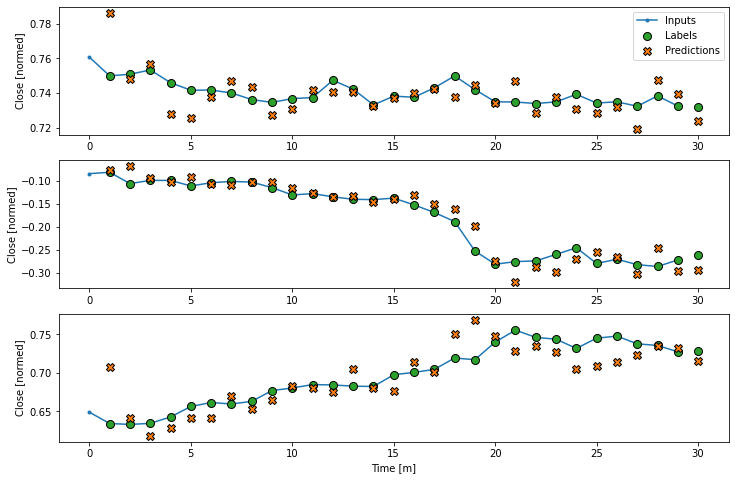

In [12]:
wide_window.plot(lstm_model)